# Real Optical Flow Torus Data Analysis

In [1]:
import matplotlib.pyplot as plt

#For bundle analysis and visualization
import circle_bundles as cb
cb.attach_bundle_viz_methods()

#For optical flow analysis and visualization
import optical_flow as of

#For local circular coordinates (optional)
from dreimac import CircularCoords


#For persistence computations
from ripser import ripser
from persim import plot_diagrams

# Get A Sample of Optical Flow Patches From The Sintel Dataset

In [2]:
import pickle 
import pandas as pd

patches_per_frame = 400
#folder_path = ".../MPI-Sintel-complete/training/flow"   #path to Sintel flow frames
folder_path = '/Users/bradturow/Desktop/TDA/MPI-Sintel-complete/training/flow'
patch_df, file_paths = of.get_patch_sample(
    folder_path,
    patches_per_frame = patches_per_frame,
    d = 3)

print('')
print(f'{len(patch_df)} optical flow patches sampled')

#Downsample if necessary
max_samples = 400000
if len(patch_df) > max_samples:
    patch_df = patch_df.sample(n=max_samples)


Finalizing dataframe... Done

416400 optical flow patches sampled


In [3]:
#Preprocess the sample
hc_frac = 0.2
max_samples = 50000
k = [300]

print('Preprocessing data...')
patch_df = of.preprocess_flow_patches(
    patch_df,
    hc_frac = hc_frac,
    max_samples = max_samples,
    k_list = k)

print('Preprocessing complete.')

preprocessing complete.


In [4]:
#Keep only the densest patches
p = 0.5
n_samples = int(p*len(patch_df))
data = np.vstack(patch_df['patch'])[:n_samples] #Data is already sorted in decreasing order by density
print(f'Downsampled to {len(data)} patches')

Downsampled to 25000 patches


# Preliminary Analysis

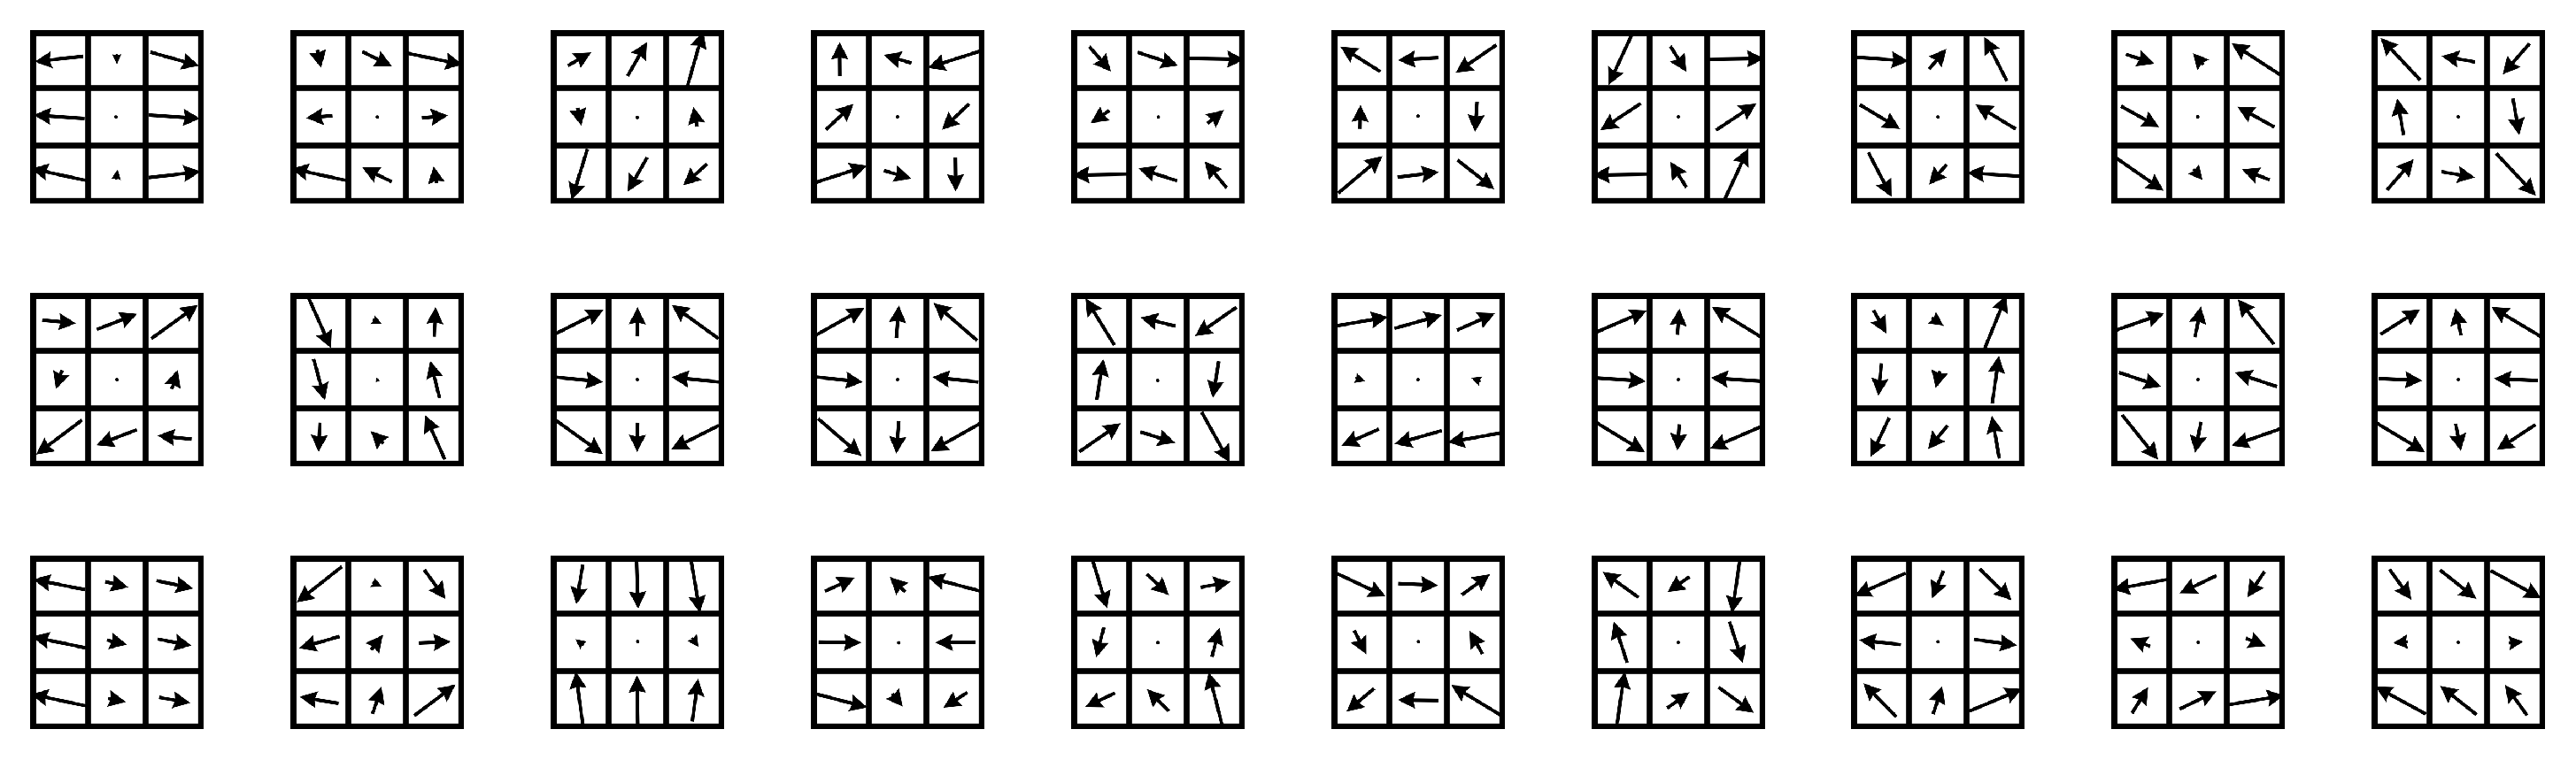

In [6]:
#View a sample of the dataset

#Create a patch visusalization function
patch_vis = of.make_patch_visualizer()

fig = cb.show_data_vis(data, patch_vis, sampling_method = None, max_samples = 30)
plt.show()

Cumulative Explained Variance:
  k=1: 0.4459
  k=2: 0.7742
  k=3: 0.8876


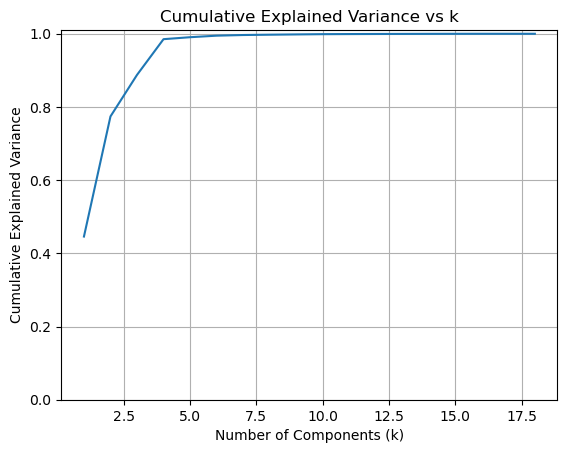

In [7]:
#Show a PCA visualization of the dataset

cb.show_pca(data)

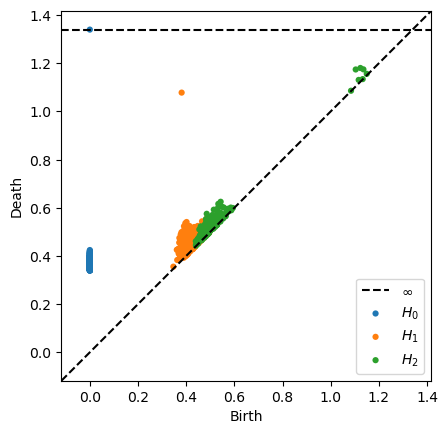

In [8]:
#Run Ripser on the dataset

diagrams = ripser(data, maxdim = 2, n_perm = 500)['dgms']
plot_diagrams(diagrams, show=True)    

# Bundle Analysis

### Cover And Nerve Summary
- $n_\text{sets} = 16$, $n_\text{samples} = 25000$

**Recorded Simplex Counts:**

- $\#(\text{0-simplices}) = 16$
- $\#(\text{1-simplices}) = 16$
- *No recorded simplices in dimensions* $\ge 2$

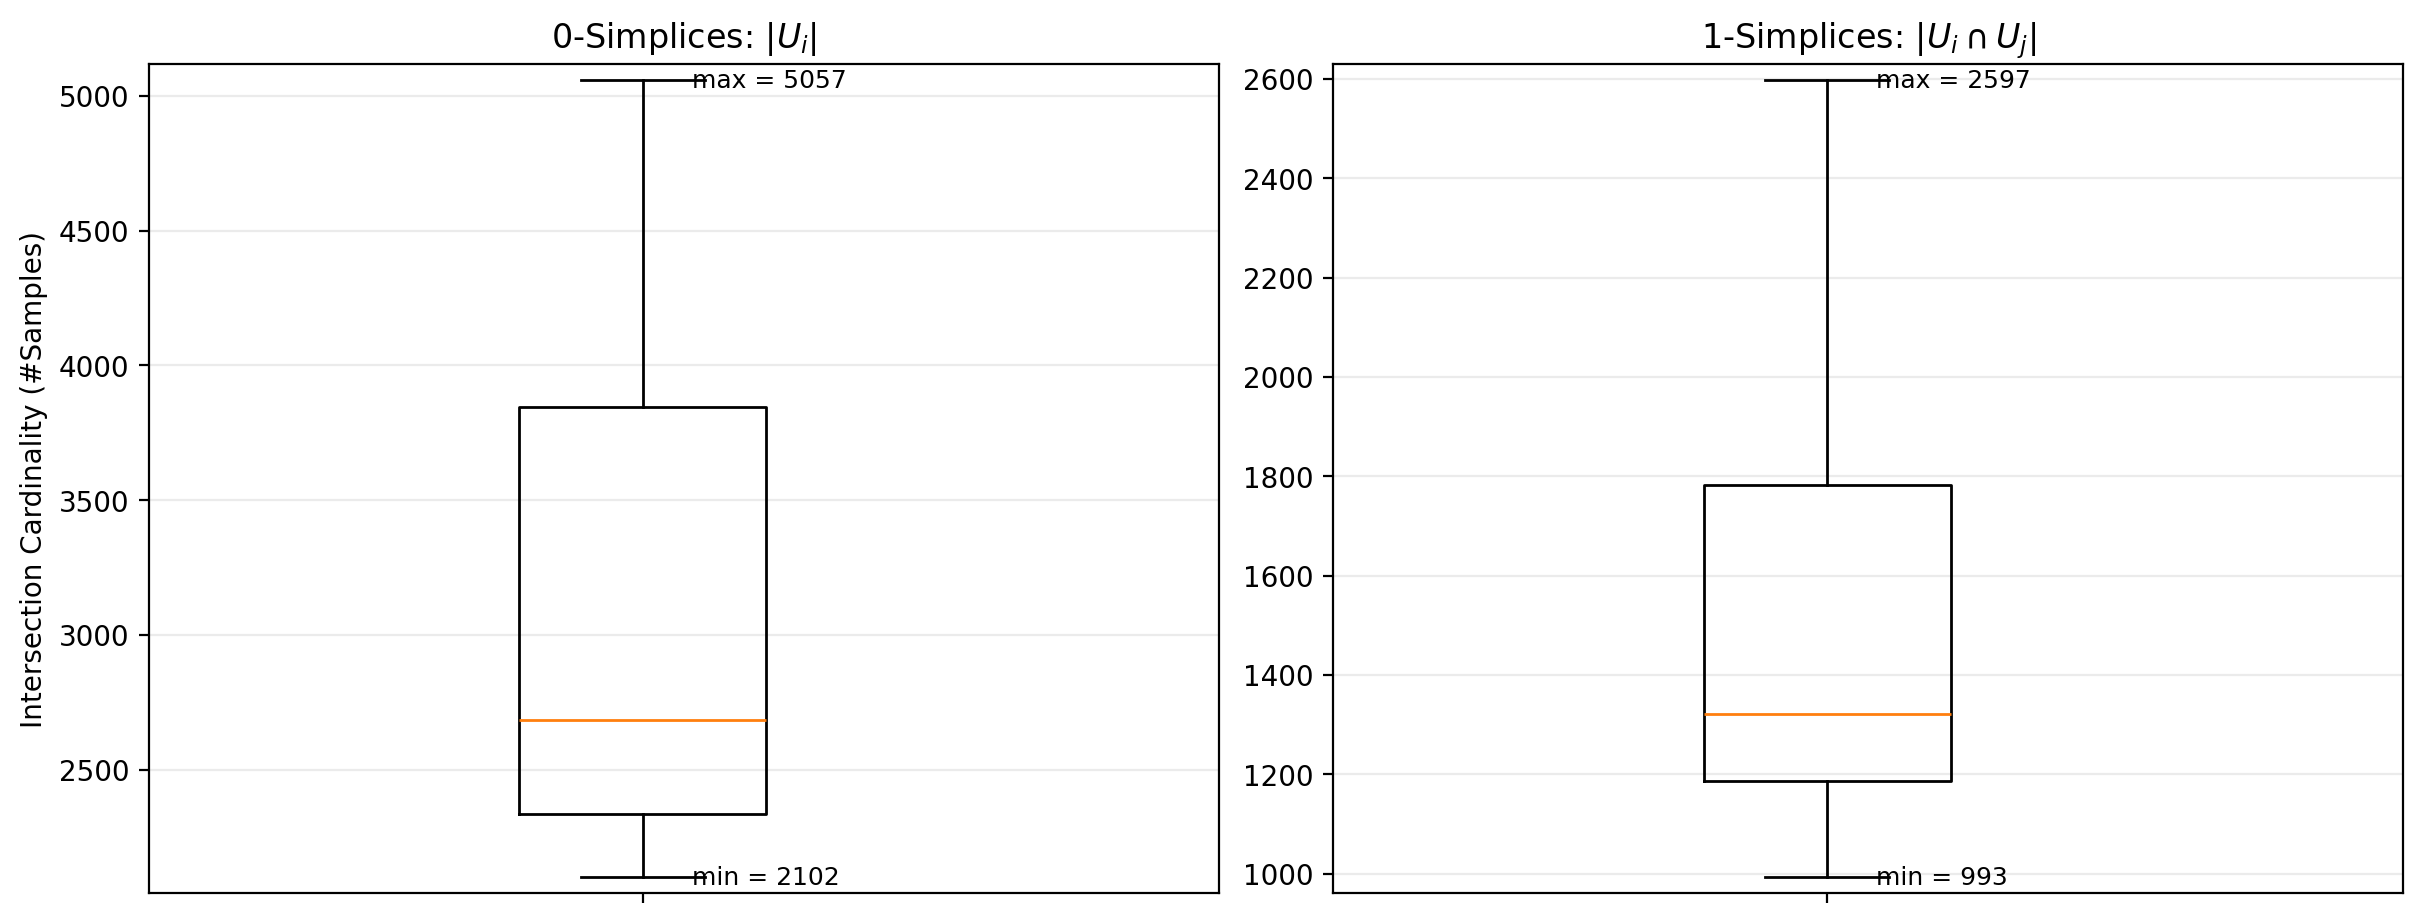

In [20]:
#Compute the predominant flow axis in RP1 for each patch and construct a cover of RP1

predom_dirs, ratios = of.get_predominant_dirs(data)    #compute directionalities for later use

#Construct a cover of the base space
n_landmarks = 16
landmarks = np.linspace(0, np.pi, n_landmarks, endpoint= False)
overlap = 1.99
radius = overlap* np.pi/(2*n_landmarks)

cover = cb.MetricBallCover(predom_dirs, landmarks, radius, metric = cb.RP1AngleMetric())
cover_data = cover.build()

#Show a summary of the construction
summ = cover.summarize(plot = True)

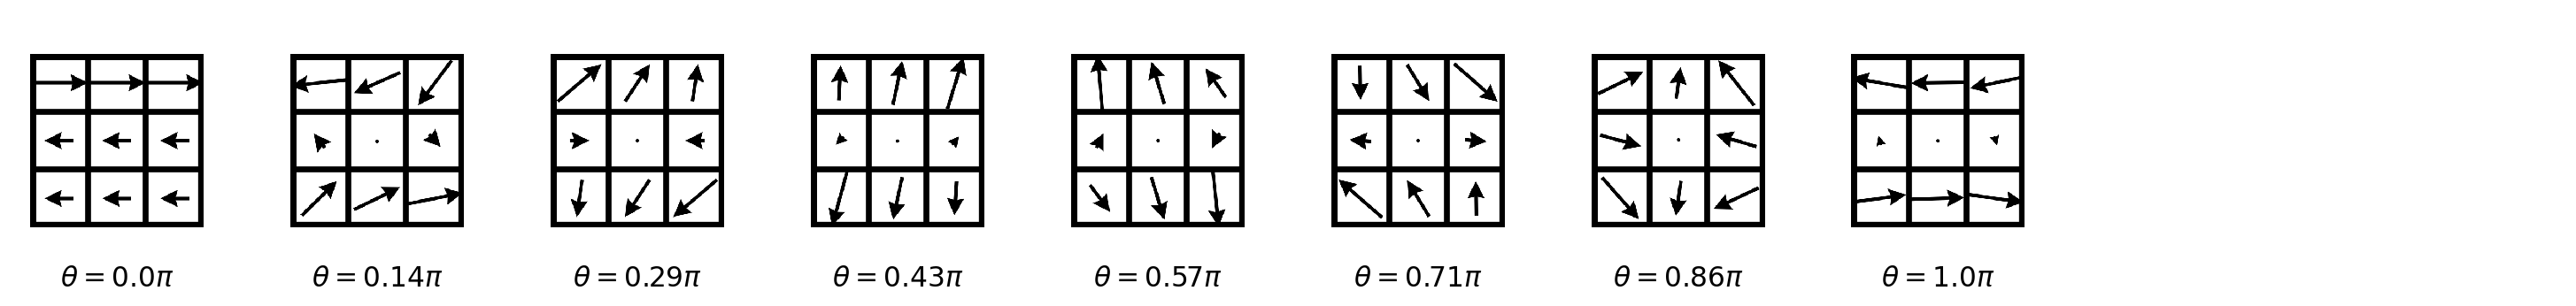

In [11]:
#View a sample of the dataset arranged by predominant flow direction
n_samples = 8

label_func = [fr"$\theta = {np.round(pred/np.pi, 2)}$" + r"$\pi$" for pred in predom_dirs]
fig = cb.show_data_vis(data, 
                       patch_vis, 
                       label_func = label_func, 
                       angles = predom_dirs, 
                       sampling_method = 'angle', 
                       max_samples = n_samples)
plt.show()


In [13]:
#Show an interactive visualization of the projection mapping
app = cb.show_bundle_vis(base_points = predom_dirs, 
                         data  = data, 
                         base_metric = cb.RP1AngleMetric(), 
                         max_samples = 5000)




Bundle viewer running at: http://127.0.0.1:59596/


In [14]:
#Construct local circular coordinates and model transitions as O(2) matrices

bundle = cb.build_bundle(
    data,
    cover,
#    CircularCoords_cls=CircularCoords,     #optionally use sparse cc algorithm
    show=True,
)


<IPython.core.display.Math object>

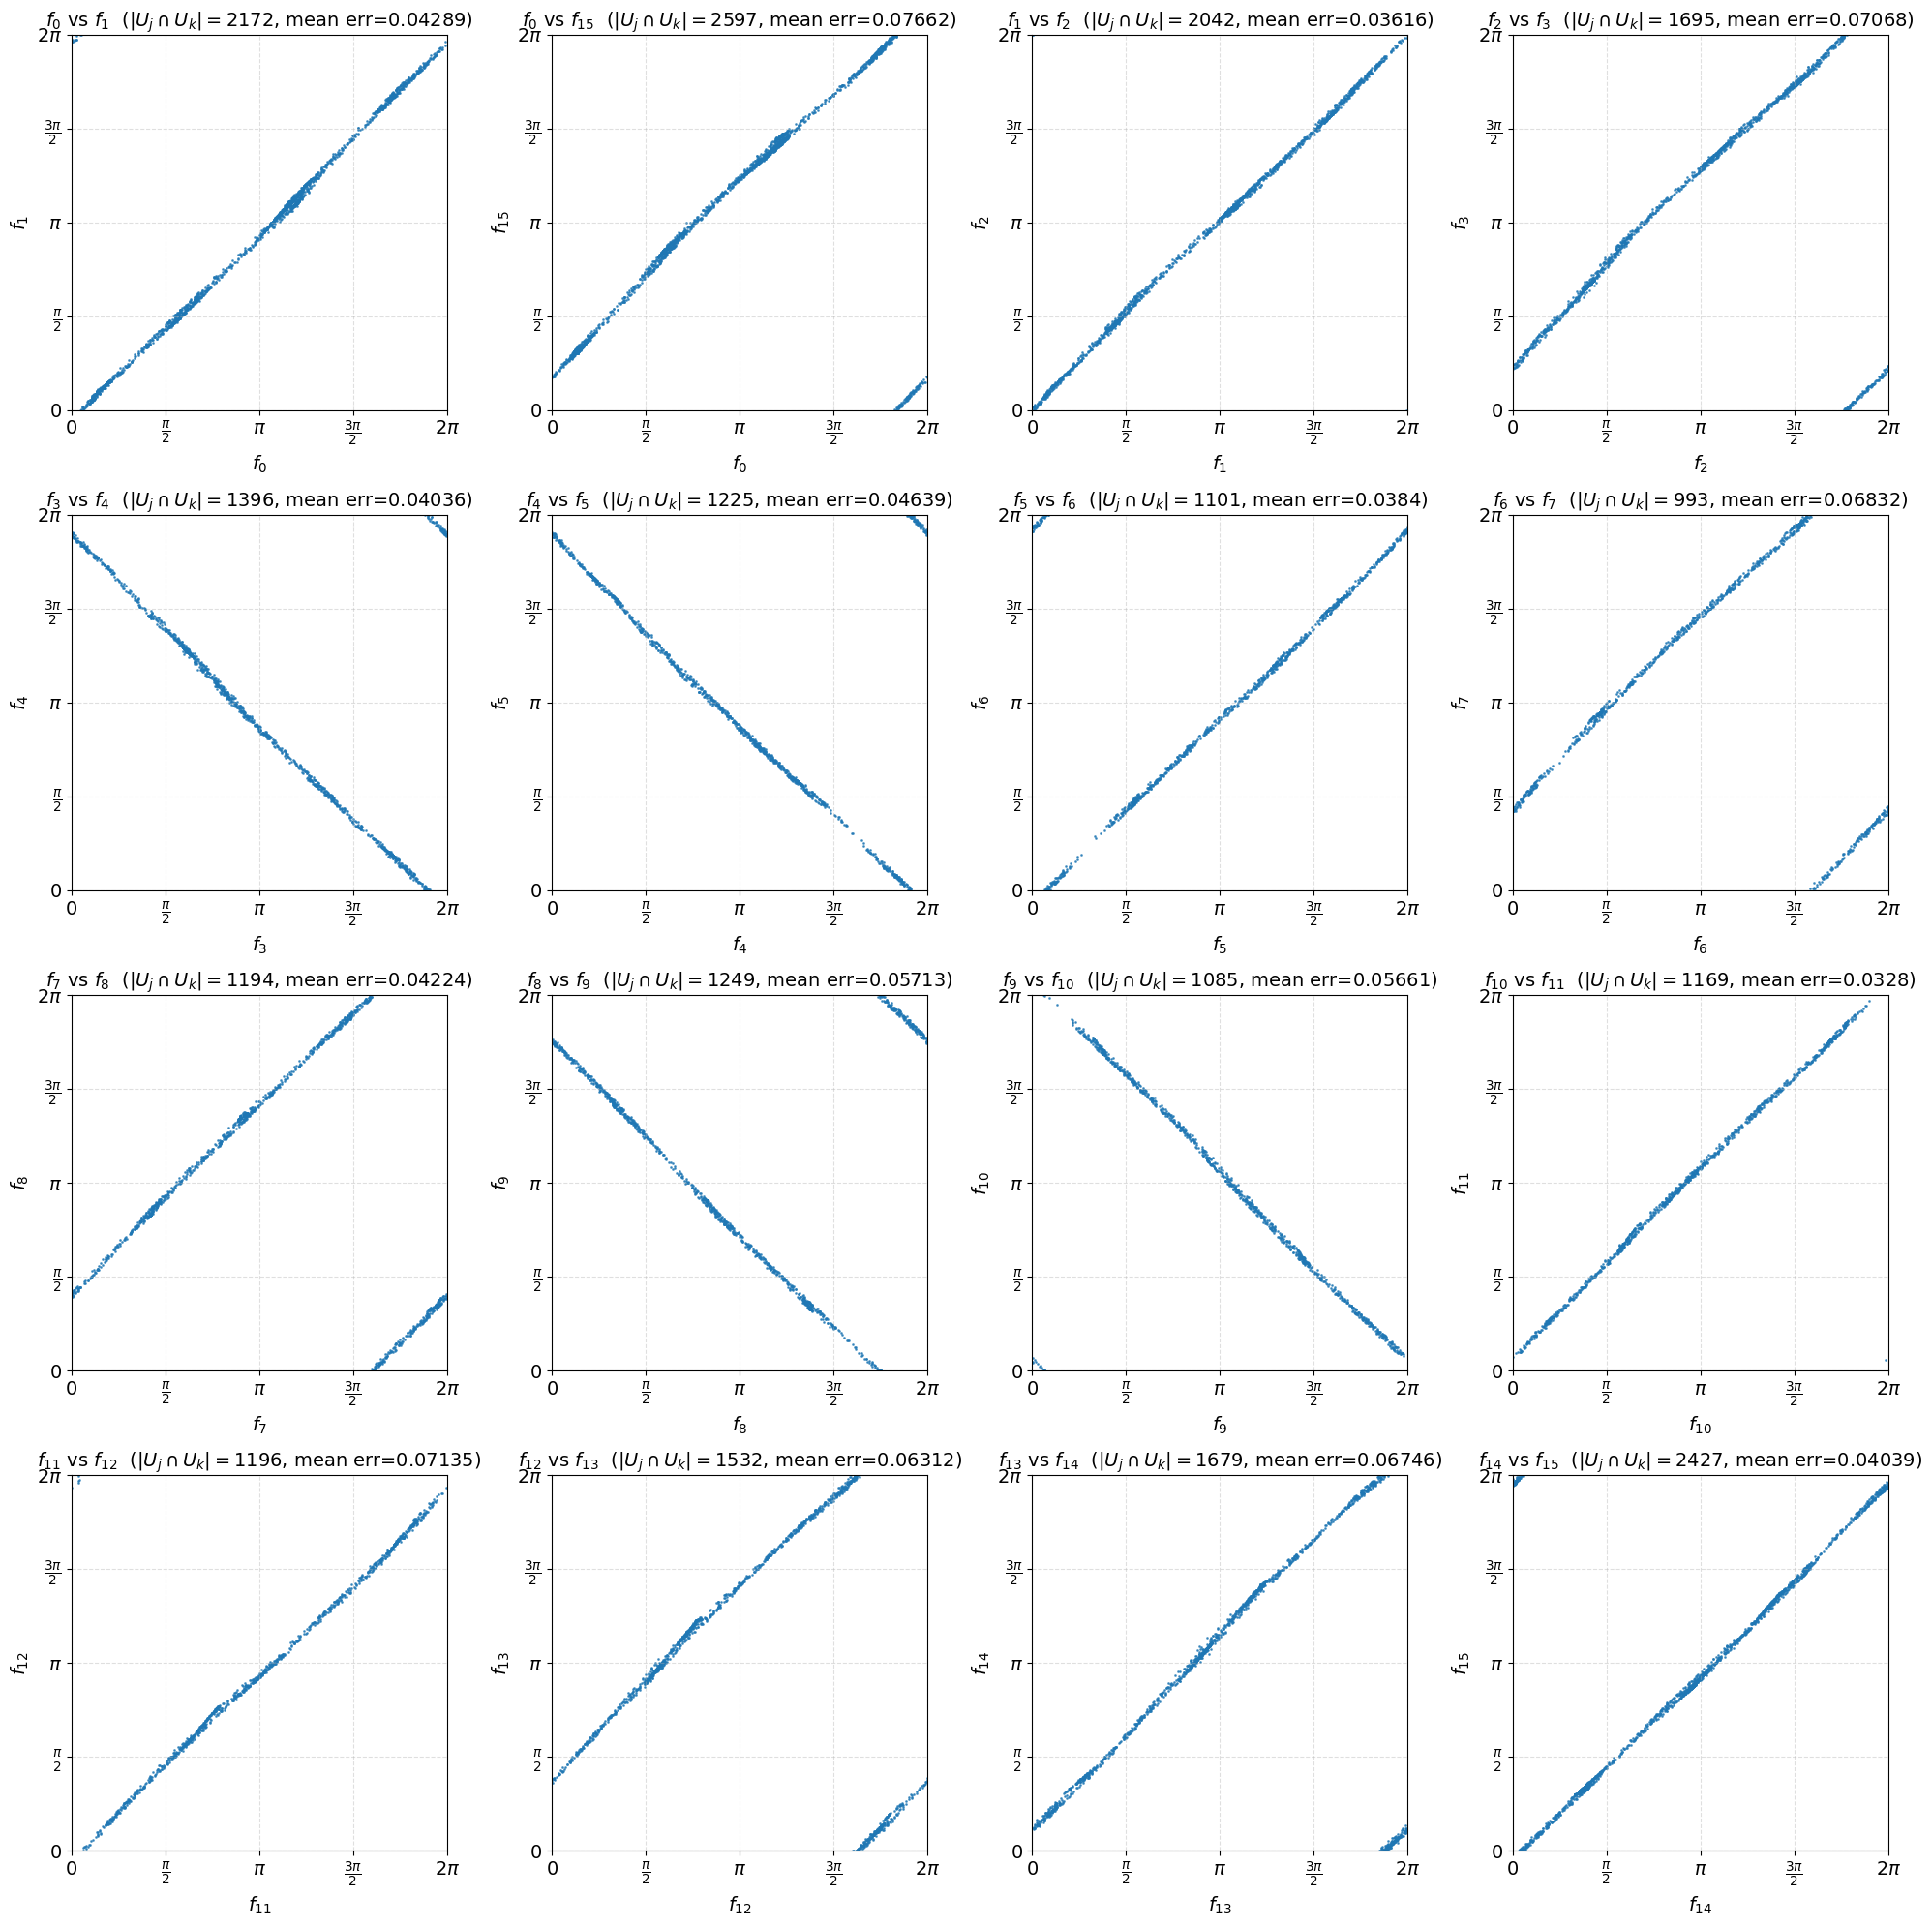

In [15]:
#View the correlations between local circular coordinates on overlaps

fig = bundle.compare_trivs(ncols = 4)
plt.show()

In [16]:
#Get a global coordinatization

triv_result = bundle.get_global_trivialization()
print('Global coordinates computed.')

Global coordinates computed.


In [17]:
#Show an interactive visualization of the bundle colored by fiber coordinate

app = bundle.show_bundle(colors = triv_result.F)


Bundle viewer running at: http://127.0.0.1:59635/


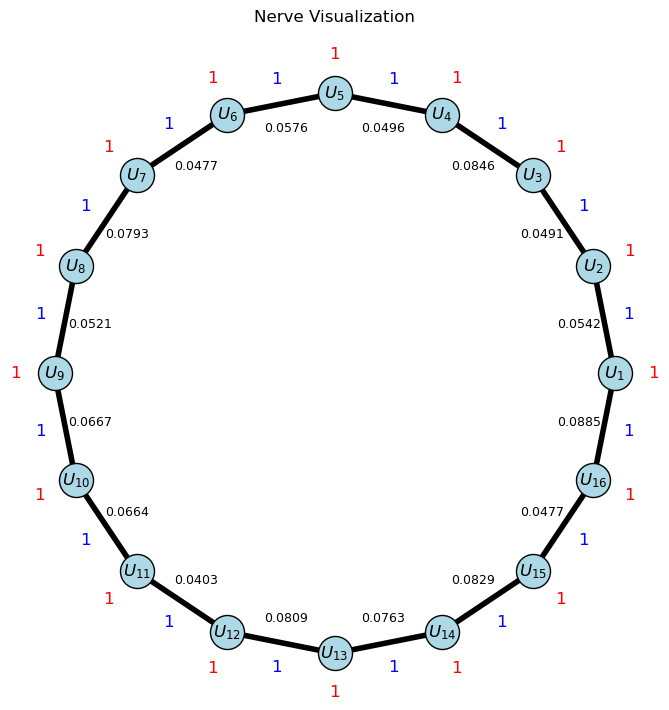

In [18]:
#Show a visualization of the nerve labeled with SW1

#Compute a potential for the restricted orientation class
subcomplex = bundle.get_max_trivial_subcomplex()
edges = subcomplex.kept_edges
Omega = bundle.classes.cocycle_used.restrict(edges)
phi_vec = Omega.orient_if_possible(edges)[2]
phi = {lmk: phi_vec[lmk] for lmk in range(n_landmarks)}
omega = bundle.classes.omega_O1_used

fig = bundle.show_circle_nerve(omega = omega, phi = phi)
plt.show()



## Restrict To High-Directionality Data 

15888 high-directionality patches


### Cover And Nerve Summary
- $n_\text{sets} = 16$, $n_\text{samples} = 15888$

**Recorded Simplex Counts:**

- $\#(\text{0-simplices}) = 16$
- $\#(\text{1-simplices}) = 16$
- *No recorded simplices in dimensions* $\ge 2$

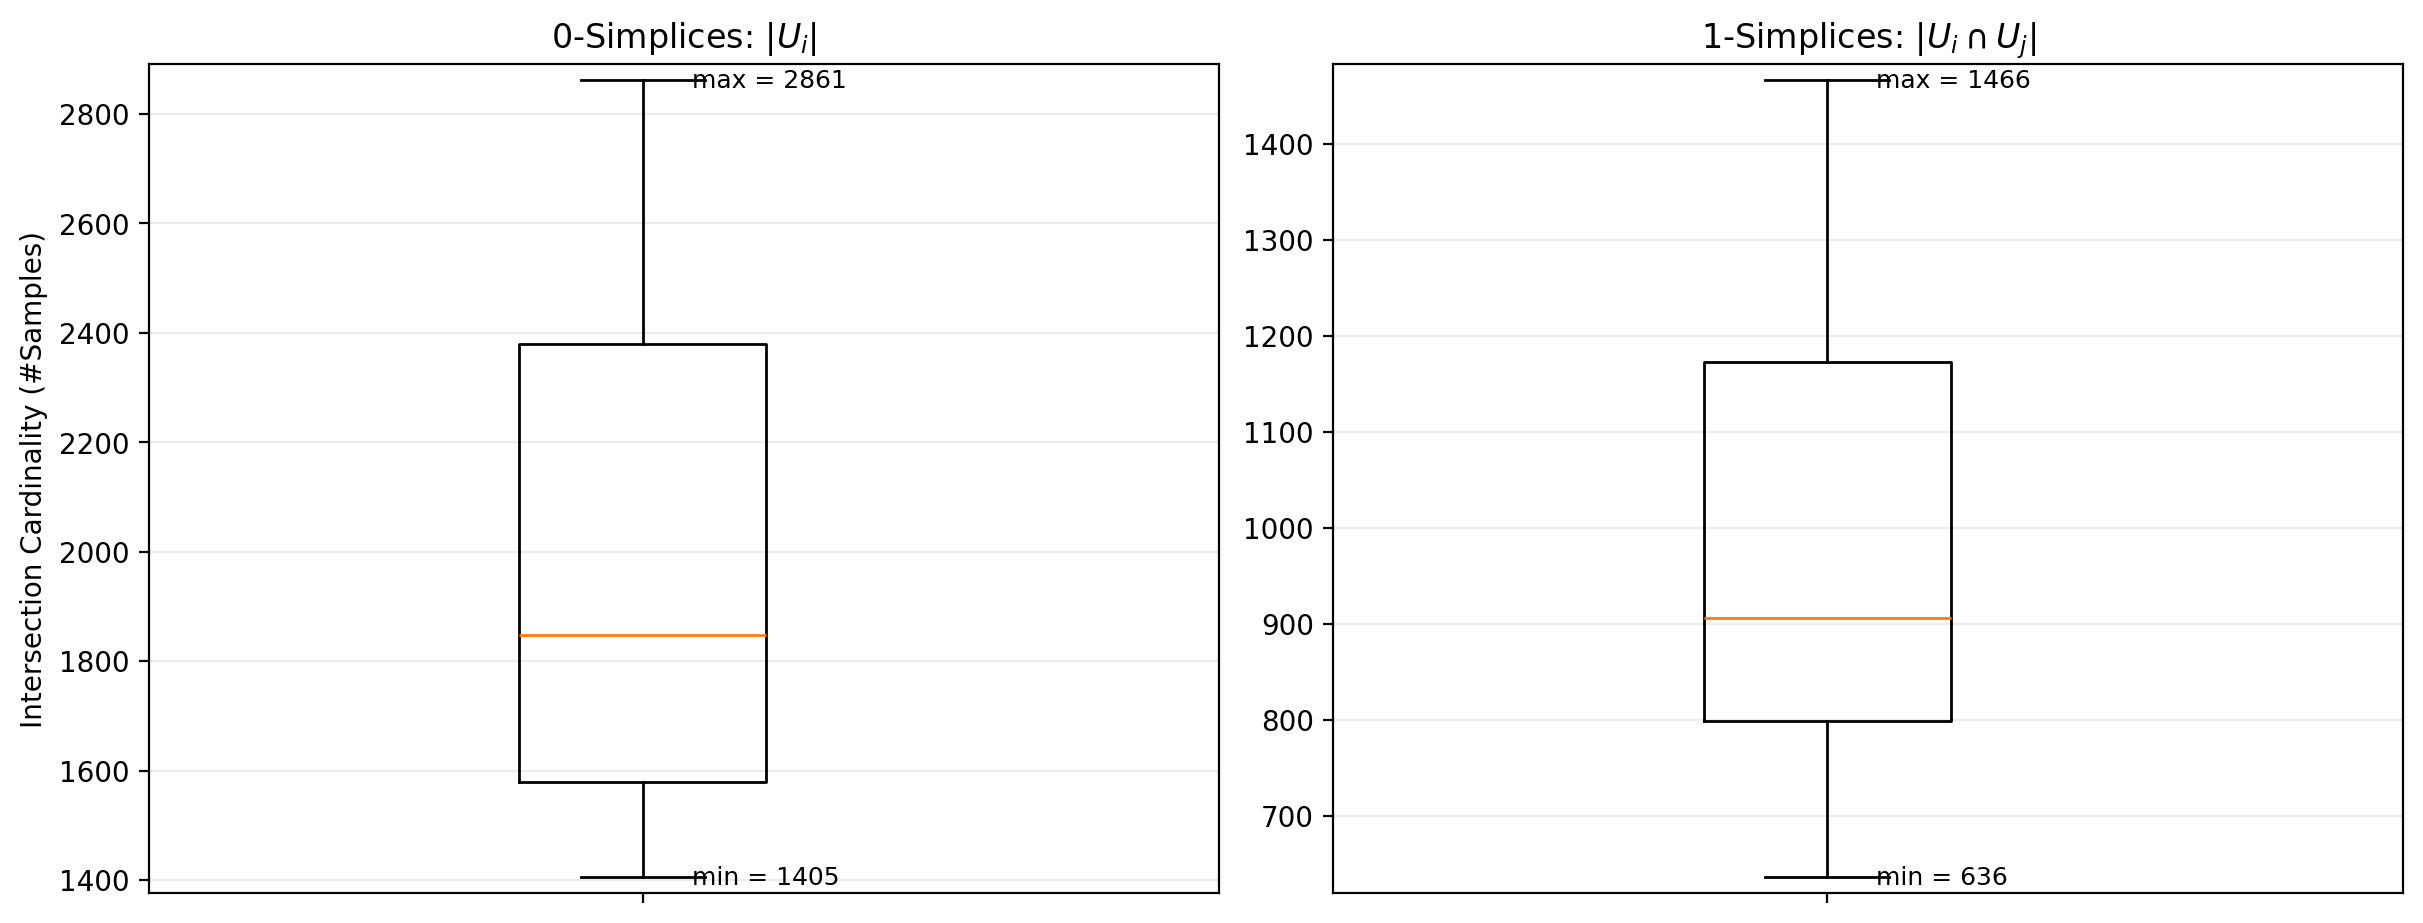

In [21]:
#Set up a bundle with just the high-directionality data
thresh = 0.8
high_inds = ratios > thresh
print(f'{np.sum(high_inds)} high-directionality patches')

high_cover = cb.MetricBallCover(predom_dirs[high_inds], landmarks, radius, metric = cb.RP1AngleMetric())
high_cover_data = high_cover.build()

#Show a summary of the construction
high_summ = high_cover.summarize(plot = True)

In [22]:
#Construct local circular coordinates and model transitions as O(2) matrices
high_bundle = cb.build_bundle(
    data[high_inds],
    high_cover,
#    CircularCoords_cls=CircularCoords,       #optionally use sparse cc algorithm
    show=True,
)


<IPython.core.display.Math object>

In [23]:
#Get global coordinates using just the high-directionality data

high_triv_result = high_bundle.get_global_trivialization()
print('global coordinates computed.')

global coordinates computed.


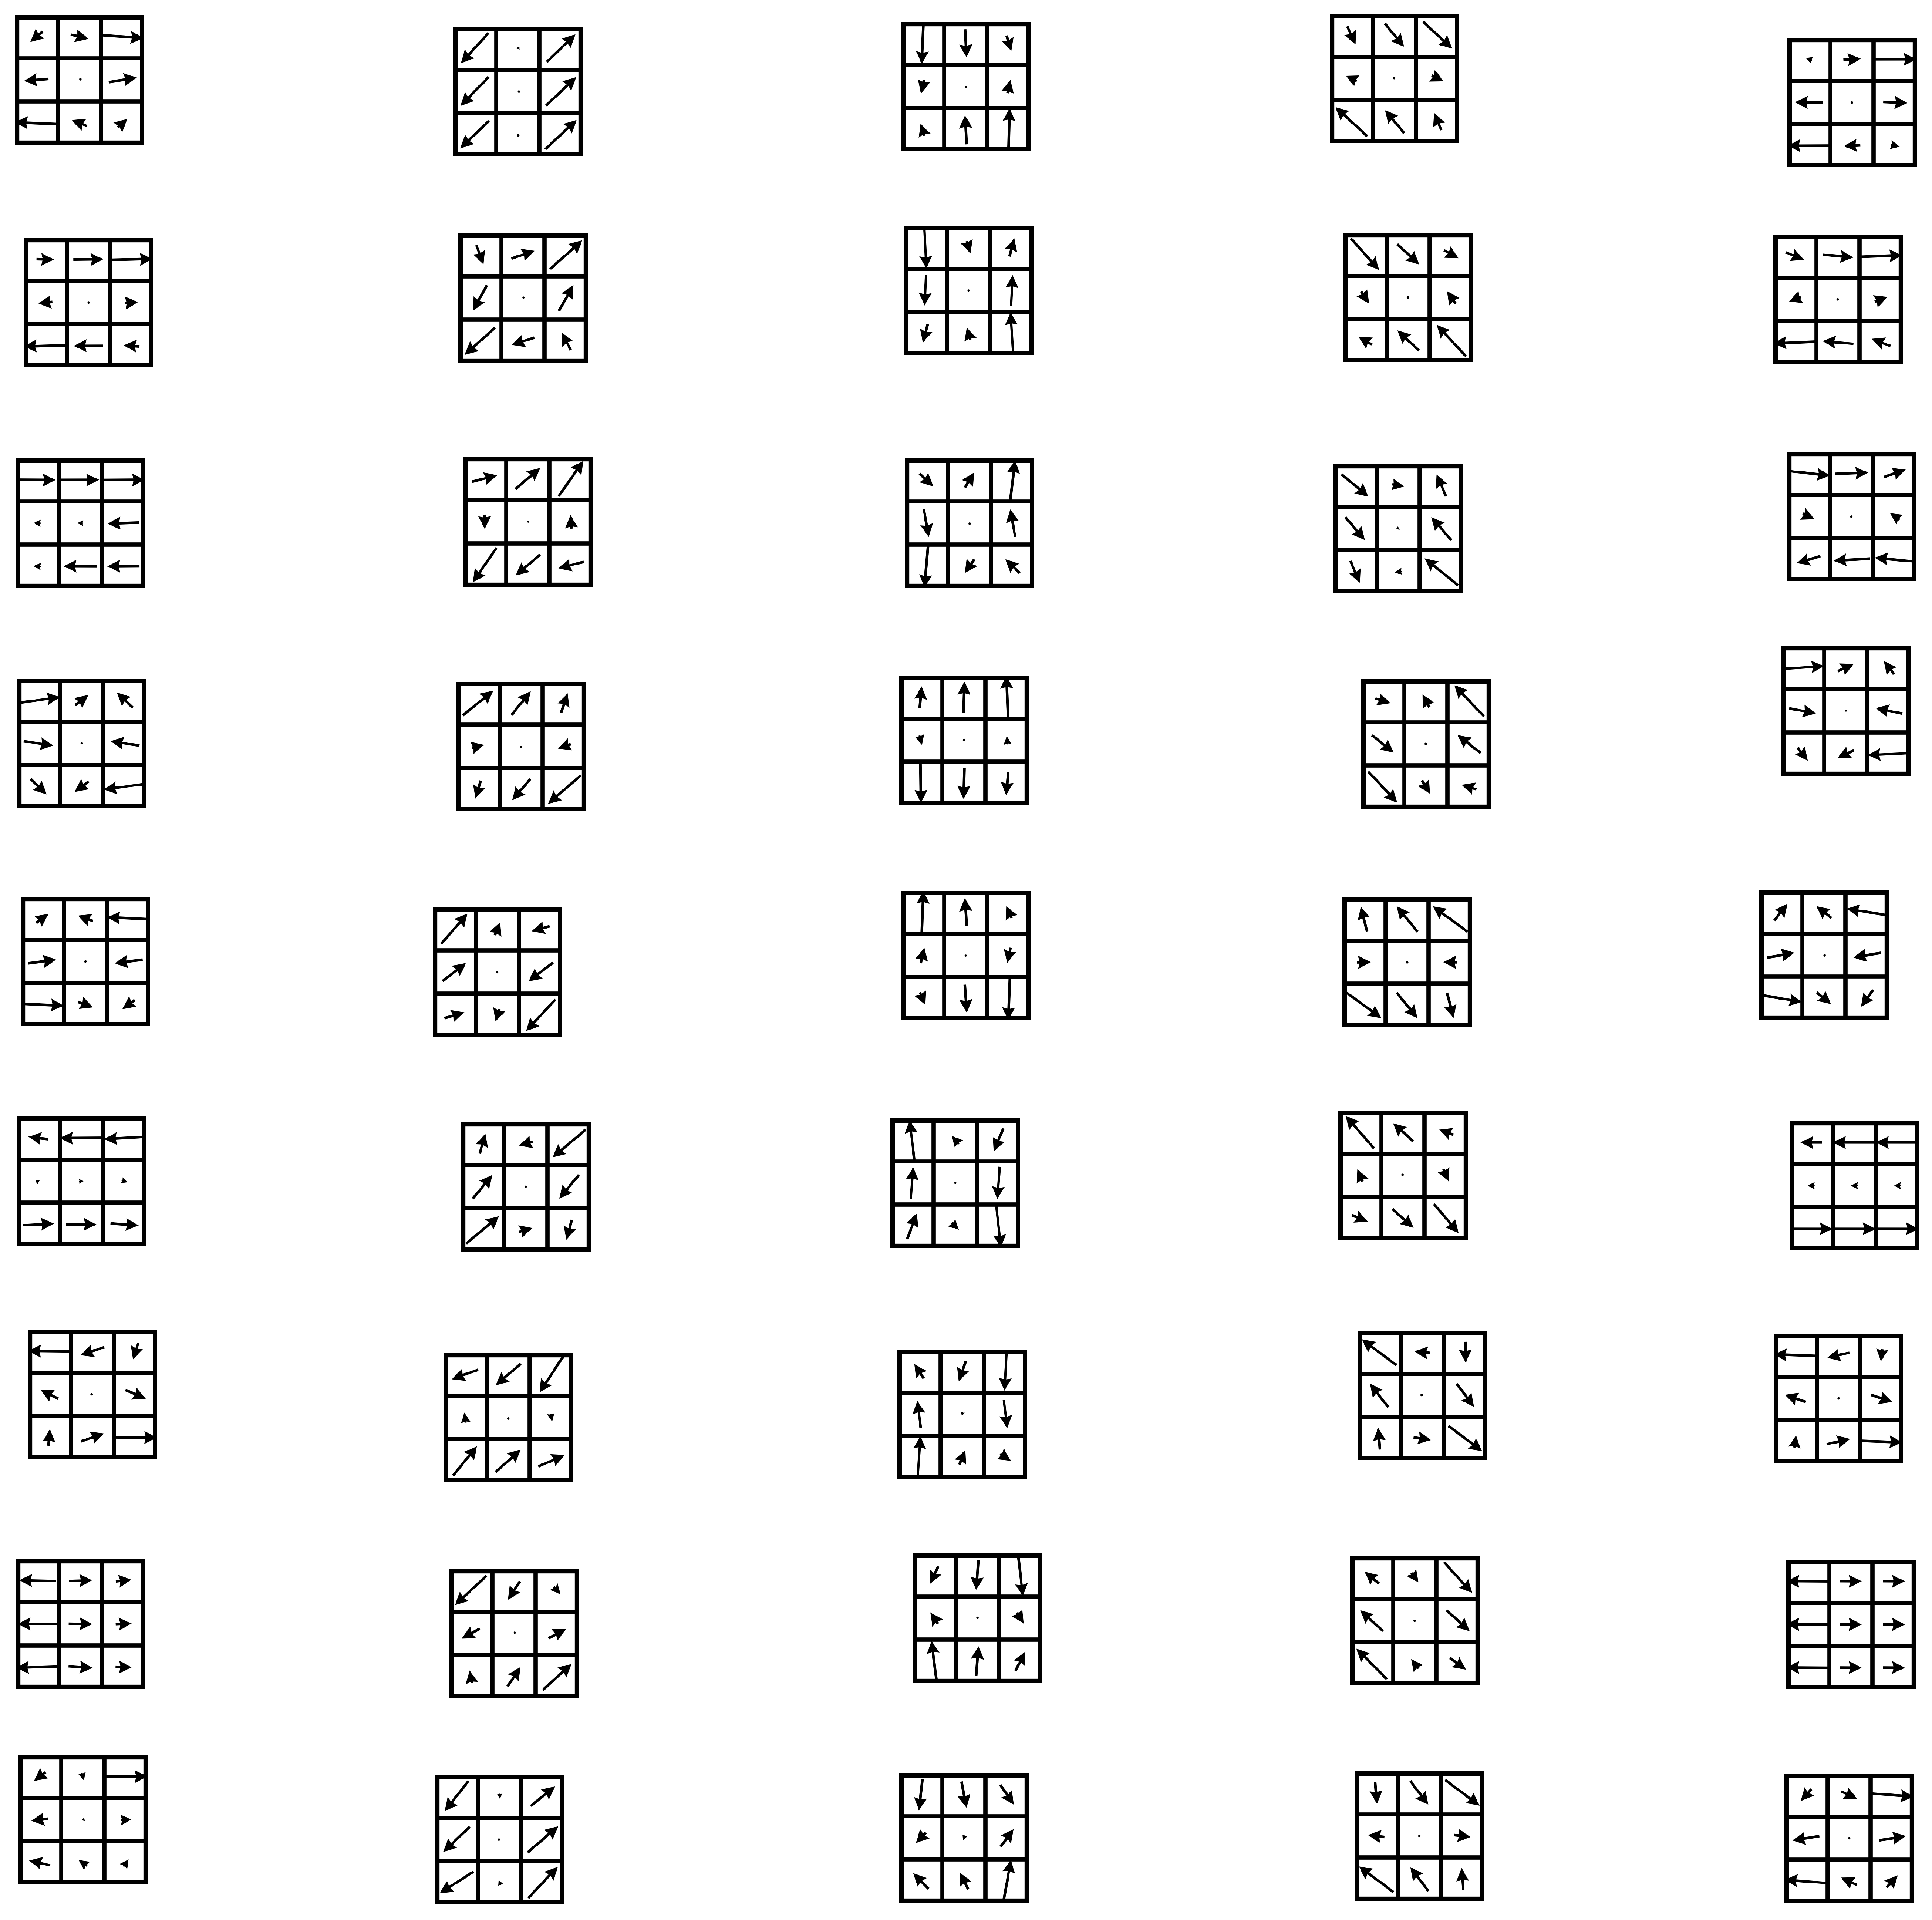

In [24]:
#Show a recovered patch diagram
per_row = 5
per_col = 9
coords = np.array([predom_dirs[high_inds], high_triv_result.F]).T

fig = cb.lattice_vis(
    high_bundle.data,
    coords,
    patch_vis,
    per_row=per_row,
    per_col = per_col,
    figsize=19,
    thumb_px=350,   
    dpi=350, 
    padding = 0
)

plt.show()


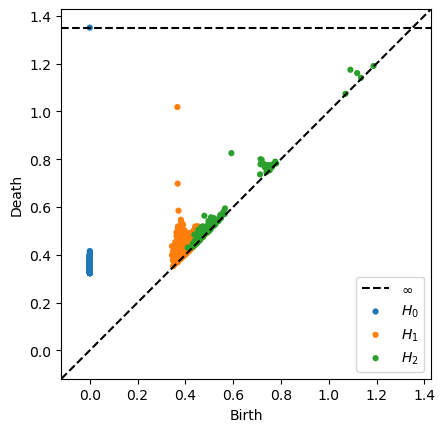

In [27]:
#Run Ripser on the high-directionality data

diagrams = ripser(high_bundle.data, maxdim = 2, n_perm = 500)['dgms']
plot_diagrams(diagrams, show=True)    

5430 low-directionality patches


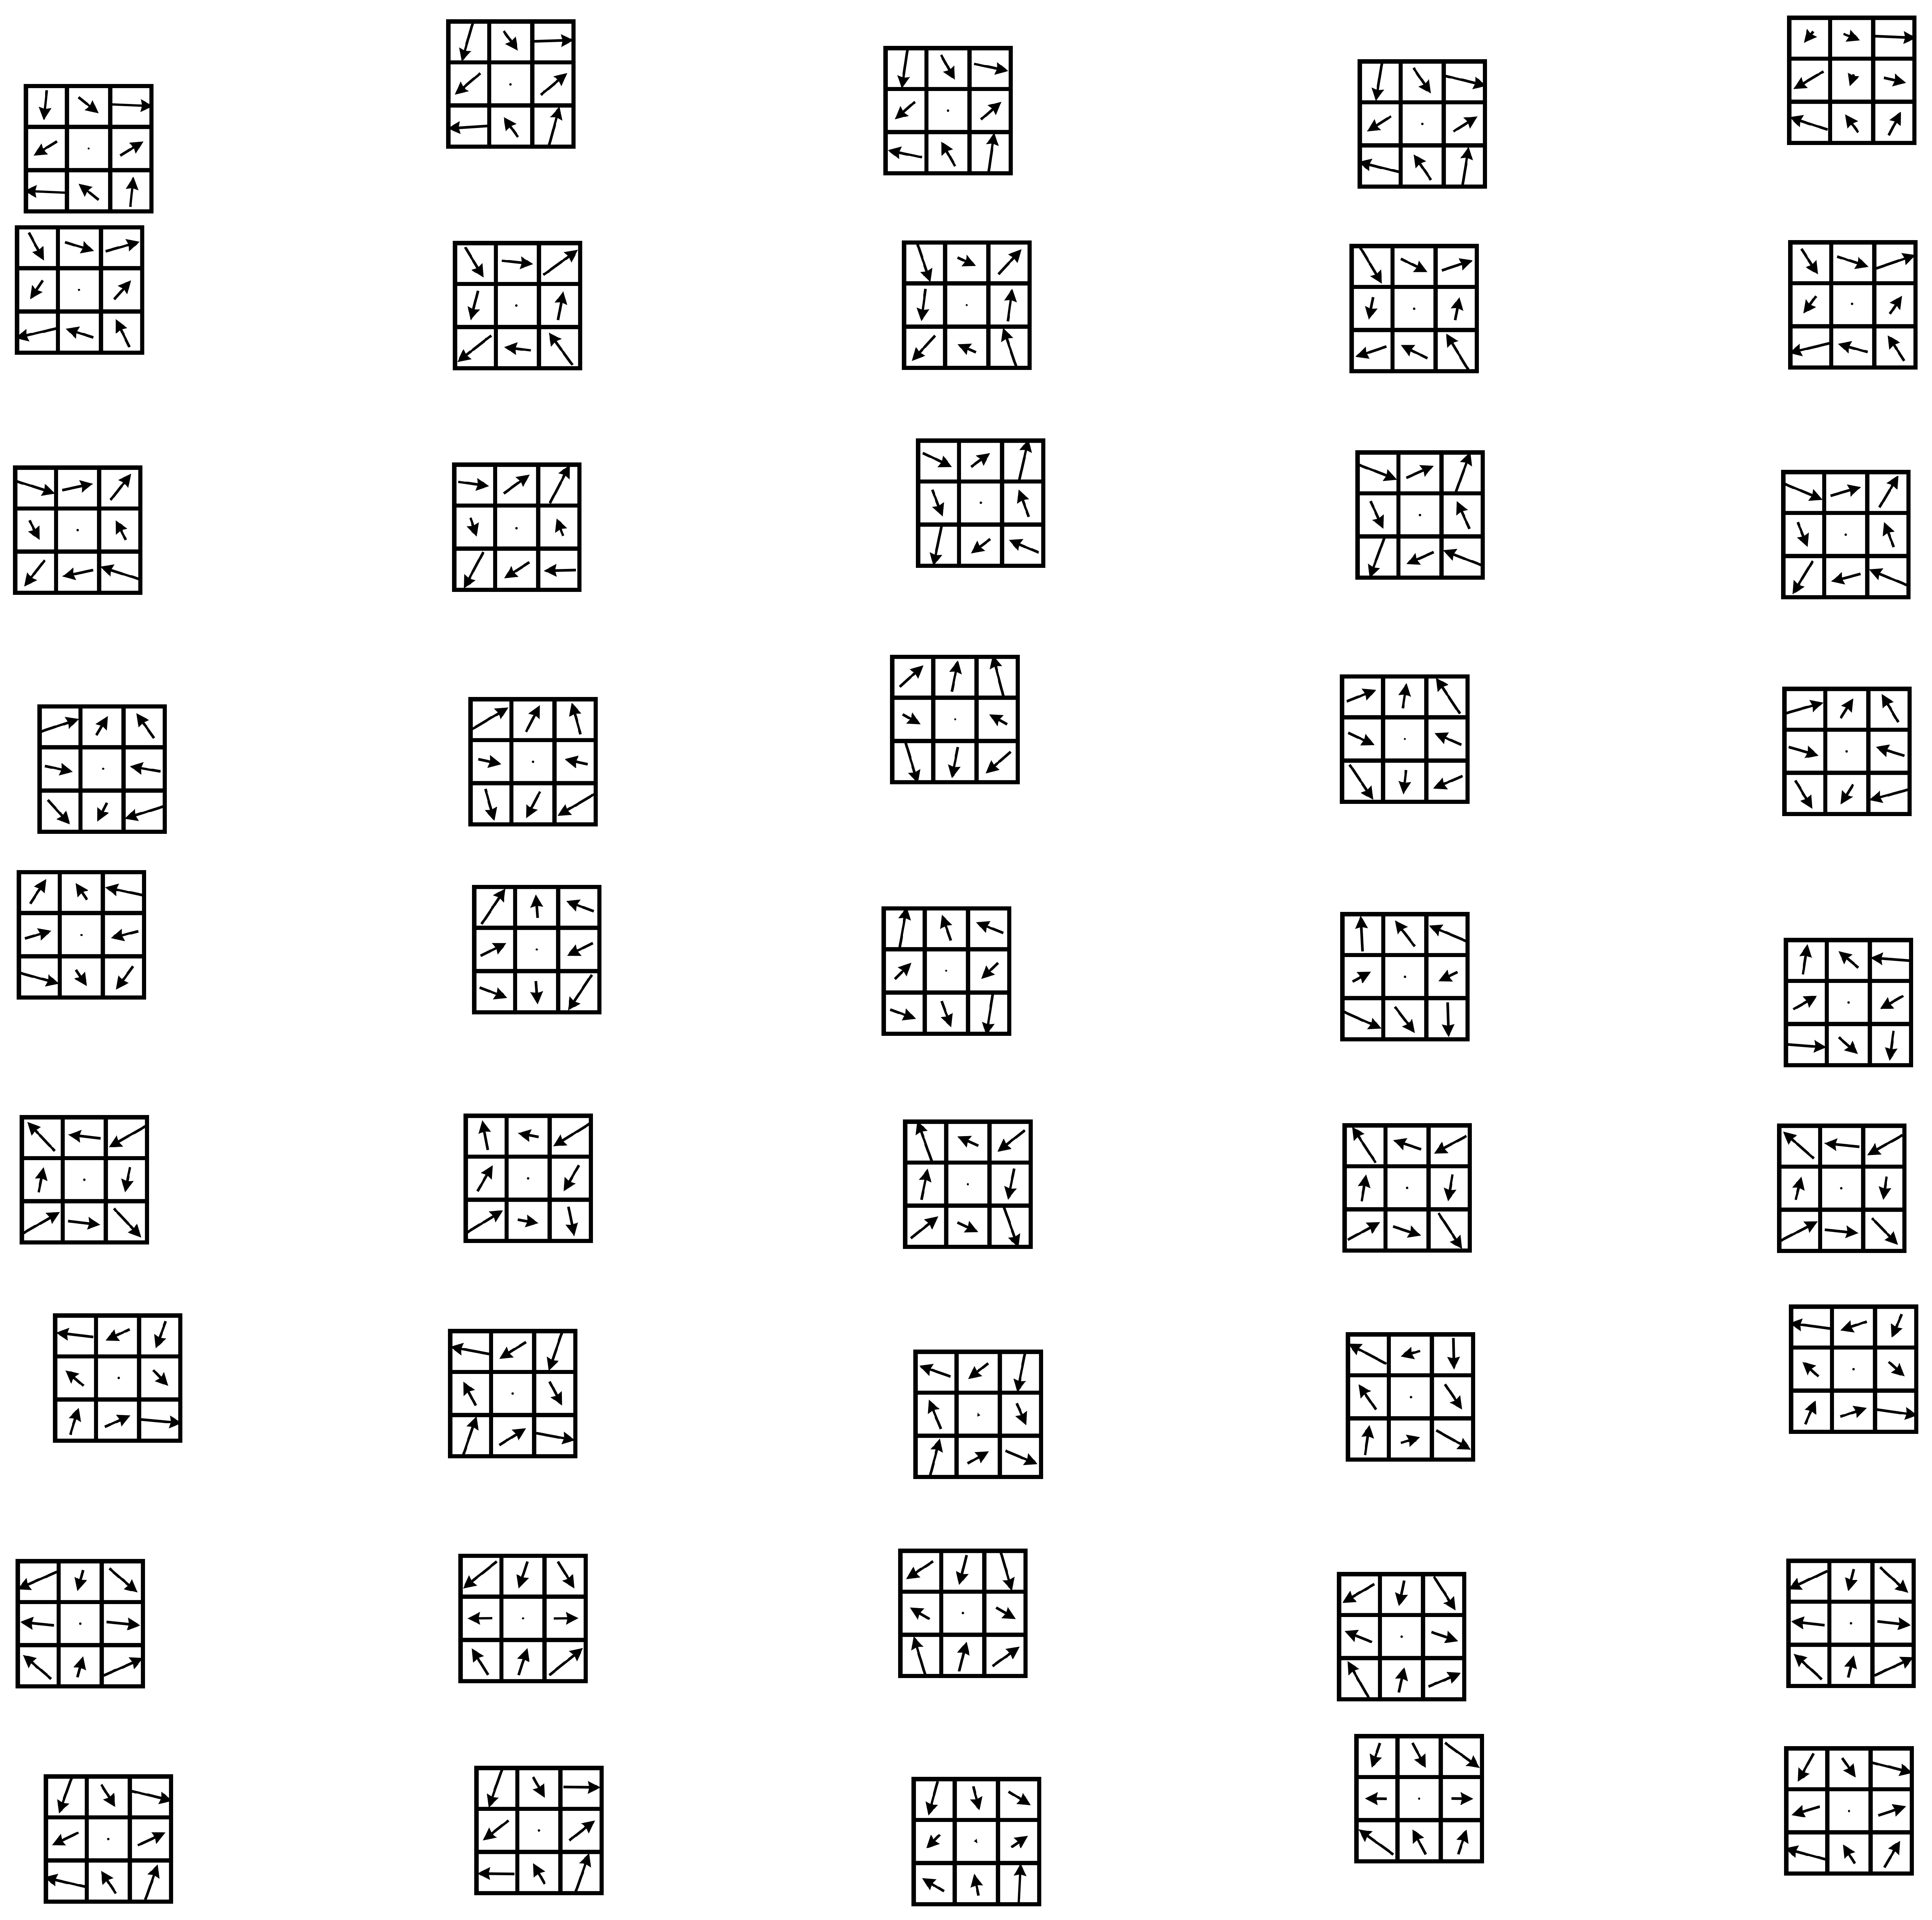

In [28]:
#Get a visualization of the low-directionality data
thresh = 0.7
low_inds = ratios < thresh
print(f'{np.sum(low_inds)} low-directionality patches')
low_data = data[low_inds]

#Show a recovered patch diagram
per_row = 5
per_col = 9
coords = np.array([predom_dirs[low_inds], triv_result.F[low_inds]]).T

fig = cb.lattice_vis(
    low_data,
    coords,
    patch_vis,
    per_row=per_row,
    per_col = per_col,
    figsize=19,
    thumb_px=350,   
    dpi=350,
    padding = 0
)

plt.show()



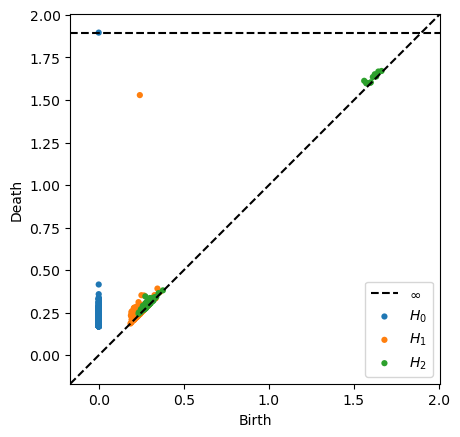

In [29]:
#Run Ripser on the low-directionality dataset

diagrams = ripser(low_data, maxdim = 2, n_perm = 500)['dgms']
plot_diagrams(diagrams, show=True)    